In [15]:
# Imports
import os
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from skimage.morphology import skeletonize
import networkx as nx
%matplotlib inline
import tensorflow as tf

In [16]:
# Configurations 
PATCH_SIZE = 256
MODEL_PATH = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/datalab_tasks/task5/celine_231265_unet_model_256px.h5"
TEST_FOLDER = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Kaggle(Retake)"
CSV_OUT_PATH = r"/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub3.csv"

# Thresholding
THRESHOLD = 0.1

# Morphology
KERNEL_SIZE = (3, 3)
KERNEL_SHAPE = cv2.MORPH_ELLIPSE
DILATE_ITERS = 5
ERODE_ITERS = 3

# ROI crop
TOP_CROP_RATIO = 0.15

# Per-plant segmentation
NUM_PLANTS = 5
MIN_AREA = 150
MARGIN_AREA_THRESH = 1200
ASPECT_RATIO_THRESHOLD = 1.5
VERTICAL_START_RATIO = 0.3
EDGE_MARGIN = 150

In [17]:
# Customs metrics 
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        tp = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
        return tp / (positives + tf.keras.backend.epsilon())
    def precision_m(y_true, y_pred):
        tp = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
        pred_pos = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
        return tp / (pred_pos + tf.keras.backend.epsilon())
    p = precision_m(y_true, y_pred)
    r = recall_m(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

# Load Model
model = load_model(MODEL_PATH, custom_objects={"f1": f1}, compile=False)

In [18]:
# Utitlities 
def pad_image(img: np.ndarray, ps: int):
    h, w = img.shape[:2]
    hp = ((h // ps) + 1) * ps - h
    wp = ((w // ps) + 1) * ps - w
    t, b = int(hp / 2), hp - int(hp / 2)
    l, r = int(wp / 2), wp - int(wp / 2)
    padded = cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)
    return padded, (t, b, l, r)

def unpad_image(img: np.ndarray, pads):
    t, b, l, r = pads
    return img[t:img.shape[0]-b, l:img.shape[1]-r]

def crop_to_dish(img: np.ndarray):
    orig_shape = img.shape
    work = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) == 3 else img
    blurred = cv2.GaussianBlur(work, (11, 11), 0)
    _, thr = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return work, {"original_shape": orig_shape, "legend_cropped": False, "used_crop": False}
    largest = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest)
    size = max(w, h)
    xc, yc = x + w // 2, y + h // 2
    xs = max(0, xc - size // 2)
    ys = max(0, yc - size // 2)
    cropped = work[ys:ys + size, xs:xs + size]
    info = {
        "original_shape": orig_shape,
        "legend_cropped": False,
        "used_crop": True,
        "x_start": xs,
        "y_start": ys,
        "crop_size": size
    }
    return cropped, info

def place_back(cropped: np.ndarray, info: dict):
    canvas = np.zeros(info["original_shape"][:2], dtype=cropped.dtype)
    if not info.get("used_crop", False):
        return cropped
    xs, ys, size = info["x_start"], info["y_start"], info["crop_size"]
    canvas[ys:ys + size, xs:xs + size] = cropped
    return canvas

In [19]:
# Inference

def generate_raw_masks(folder_path: str, model, patch_size: int = PATCH_SIZE):
    results = {}
    for filename in sorted(os.listdir(folder_path)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
            continue

        print(f"\nProcessing {filename}")
        img_path = os.path.join(folder_path, filename)
        gray = cv2.imread(img_path, 0)
        h, w = gray.shape
        print(f"Original image shape: {h} x {w}")

        dish, crop_info = crop_to_dish(gray)
        dish_pad, pad_info = pad_image(dish, patch_size)

        patches = patchify(dish_pad, (patch_size, patch_size), step=128)
        ph, pw = patches.shape[:2]
        patches_rgb = np.repeat(patches, 3, axis=-1)
        model_in = patches_rgb.reshape(-1, patch_size, patch_size, 3) / 255.0

        preds = model.predict(model_in, verbose=1)
        preds = preds.squeeze().reshape(ph, pw, patch_size, patch_size)

        mask_pred = unpatchify(preds, dish_pad.shape)
        mask_unpad = unpad_image(mask_pred, pad_info)
        mask_aligned = place_back(mask_unpad, crop_info)

        results[filename] = {'mask': mask_aligned, 'crop_info': crop_info, 'pad_info': pad_info}
    return results

raw_predictions = generate_raw_masks(TEST_FOLDER, model)


Processing test_image_1.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step

Processing test_image_10.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step

Processing test_image_11.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step

Processing test_image_2.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step

Processing test_image_3.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step

Processing test_image_4.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step

Processing test_image_5.tif
Original image shape: 2999 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step

Processing test_image_6.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step

Processing test_image_7.tif
Original image shape: 3006 x 4202
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step

Processing test_image_8.tif
Original image shape: 3006 x 4202
1

In [20]:
#Thresholding 
thresholded_masks = {}
for name, raw in raw_predictions.items():
    m = raw['mask']
    thresholded_masks[name] = (m > THRESHOLD).astype(np.uint8)

# Morphological closing 
closed_masks = {}
kernel = cv2.getStructuringElement(KERNEL_SHAPE, KERNEL_SIZE)
for name, binary in thresholded_masks.items():
    base = binary.copy()
    dilated = cv2.dilate(base, kernel, iterations=DILATE_ITERS)
    closed = cv2.erode(dilated, kernel, iterations=ERODE_ITERS)
    closed_masks[name] = closed

In [21]:
# ROI crop to dish width 
dish_cropped_masks = {}
for name, closed in closed_masks.items():
    ci = raw_predictions[name]['crop_info']
    xs, size = ci['x_start'], ci['crop_size']
    xe = min(xs + size, closed.shape[1])
    horiz = closed[:, xs:xe]
    h = horiz.shape[0]
    t = int(h * TOP_CROP_RATIO)
    dish_cropped_masks[name] = horiz[t:, :]

In [22]:
# Per-plant segmentation (connected components) 
def segment_roots_per_plant(mask: np.ndarray, cfg: dict) -> list:
    h, w = mask.shape
    band_w = w / cfg['NUM_PLANTS']
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
    bands = [np.zeros_like(mask, dtype=np.uint8) for _ in range(cfg['NUM_PLANTS'])]

    for lbl in range(1, num_labels):
        x, y, cw, ch, area = stats[lbl]
        if area < cfg['MIN_AREA']:
            continue
        if area < cfg['MARGIN_AREA_THRESH'] and (x + cw > w - cfg['EDGE_MARGIN'] or x < cfg['EDGE_MARGIN']):
            continue
        ar = ch / cw if cw > 0 else 0
        if ar < cfg['ASPECT_RATIO_THRESHOLD']:
            continue
        if y > int(h * cfg['VERTICAL_START_RATIO']):
            continue

        cx = centroids[lbl][0]
        band_idx = int(cx / band_w)
        if band_idx >= cfg['NUM_PLANTS']:
            band_idx = cfg['NUM_PLANTS'] - 1

        comp = (labels == lbl).astype(np.uint8)
        if np.count_nonzero(bands[band_idx]) < area:
            bands[band_idx] = comp

    return [(m * 255).astype(np.uint8) for m in bands]

seg_cfg = {
    'NUM_PLANTS': NUM_PLANTS,
    'MIN_AREA': MIN_AREA,
    'MARGIN_AREA_THRESH': MARGIN_AREA_THRESH,
    'ASPECT_RATIO_THRESHOLD': ASPECT_RATIO_THRESHOLD,
    'VERTICAL_START_RATIO': VERTICAL_START_RATIO,
    'EDGE_MARGIN': EDGE_MARGIN,
}

segmented_root_masks = {name: segment_roots_per_plant(mask, seg_cfg)
                        for name, mask in dish_cropped_masks.items()}

In [23]:
final_root_masks = {}
for name, plant_masks in segmented_root_masks.items():
    base_name = os.path.splitext(name)[0]
    for idx, m in enumerate(plant_masks):
        plant_num = idx + 1
        key = f"{base_name}_plant_{plant_num}"
        final_root_masks[key] = m
        print(f"Stored: {key}")

Stored: test_image_1_plant_1
Stored: test_image_1_plant_2
Stored: test_image_1_plant_3
Stored: test_image_1_plant_4
Stored: test_image_1_plant_5
Stored: test_image_10_plant_1
Stored: test_image_10_plant_2
Stored: test_image_10_plant_3
Stored: test_image_10_plant_4
Stored: test_image_10_plant_5
Stored: test_image_11_plant_1
Stored: test_image_11_plant_2
Stored: test_image_11_plant_3
Stored: test_image_11_plant_4
Stored: test_image_11_plant_5
Stored: test_image_2_plant_1
Stored: test_image_2_plant_2
Stored: test_image_2_plant_3
Stored: test_image_2_plant_4
Stored: test_image_2_plant_5
Stored: test_image_3_plant_1
Stored: test_image_3_plant_2
Stored: test_image_3_plant_3
Stored: test_image_3_plant_4
Stored: test_image_3_plant_5
Stored: test_image_4_plant_1
Stored: test_image_4_plant_2
Stored: test_image_4_plant_3
Stored: test_image_4_plant_4
Stored: test_image_4_plant_5
Stored: test_image_5_plant_1
Stored: test_image_5_plant_2
Stored: test_image_5_plant_3
Stored: test_image_5_plant_4
Stor

In [24]:
# Primary root length (skeleton + Dijkstra)
primary_root_lengths = {}
for key, m in final_root_masks.items():
    binary = (m > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)

    if num_labels <= 1:
        primary_root_lengths[key] = 0.00
        continue

    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    comp = (labels == largest).astype(np.uint8)

    x, y, w, h, _ = stats[largest]
    cropped = comp[y:y+h, x:x+w]
    skel = skeletonize(cropped)

    G = nx.Graph()
    coords = np.argwhere(skel)
    coord_set = set(map(tuple, coords))
    for y0, x0 in coords:
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1),
                       (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            nb = (y0 + dy, x0 + dx)
            if nb in coord_set:
                G.add_edge((y0, x0), nb, weight=np.hypot(dy, dx))

    if G.number_of_nodes() == 0:
        primary_root_lengths[key] = 0.00
        continue

    top_node = min(G.nodes, key=lambda n: n[0])
    bottom_node = max(G.nodes, key=lambda n: n[0])

    try:
        path_len = nx.dijkstra_path_length(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        path_len = 0.0

    primary_root_lengths[key] = round(path_len, 2)


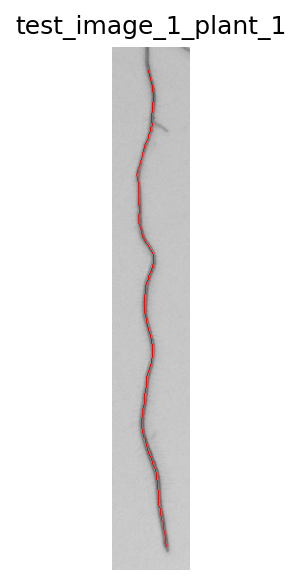

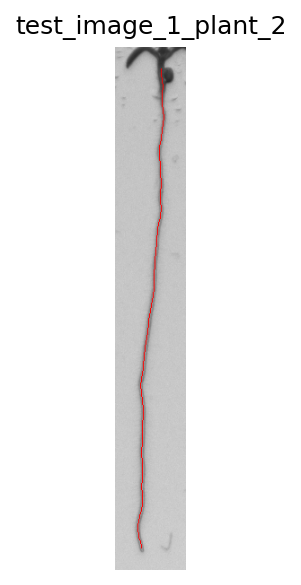

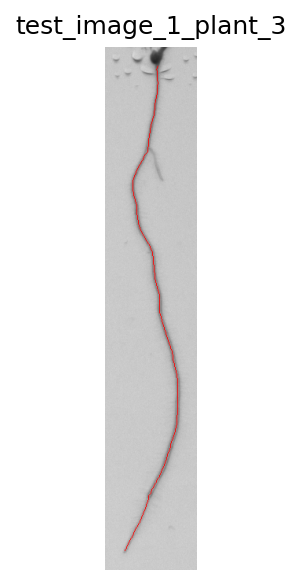

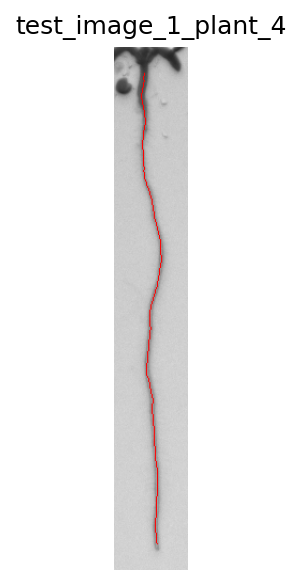

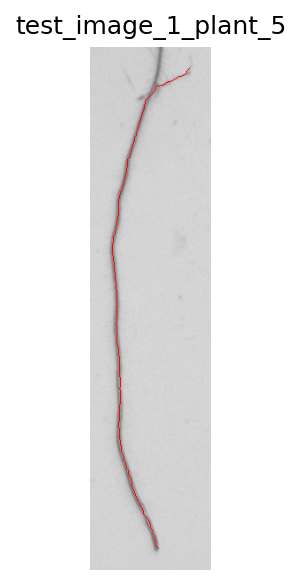

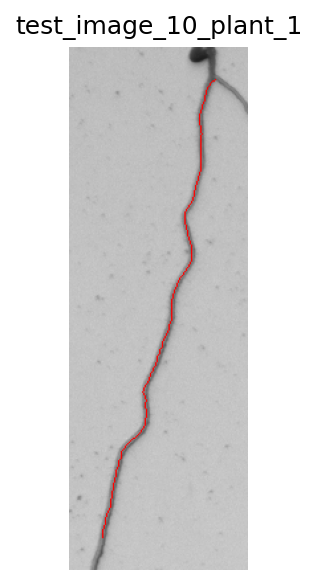

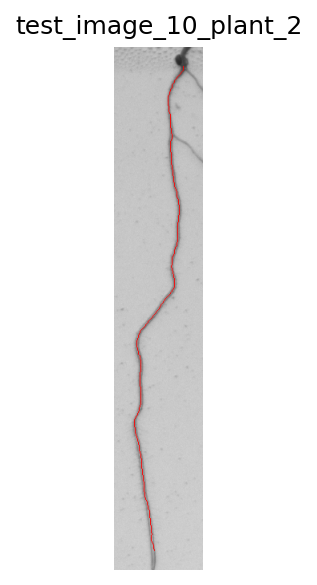

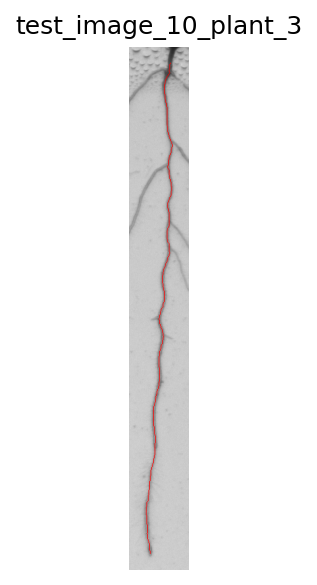

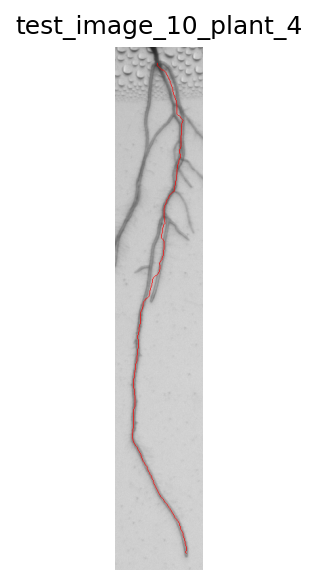

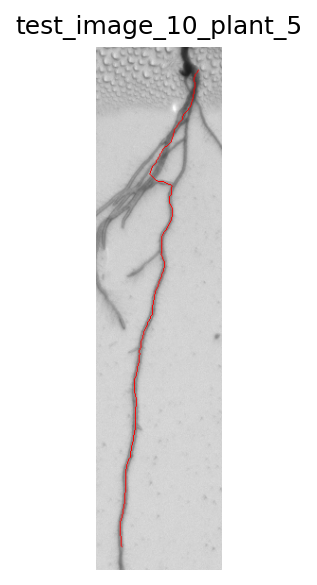

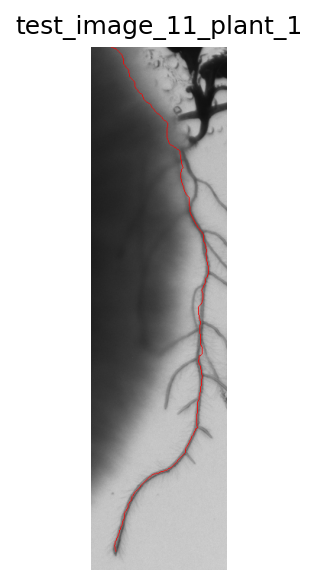

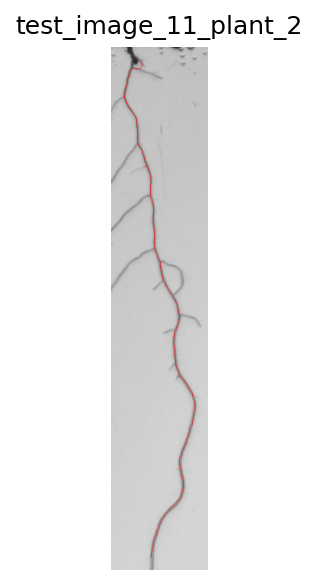

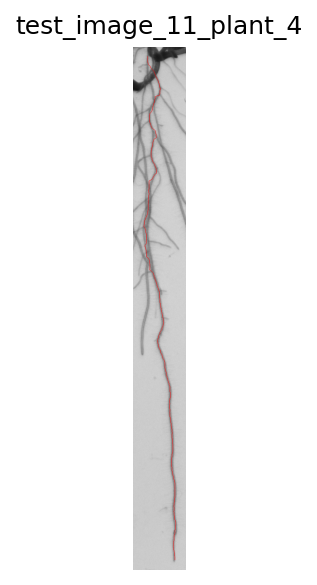

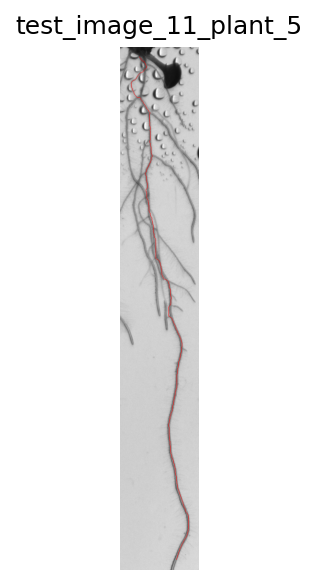

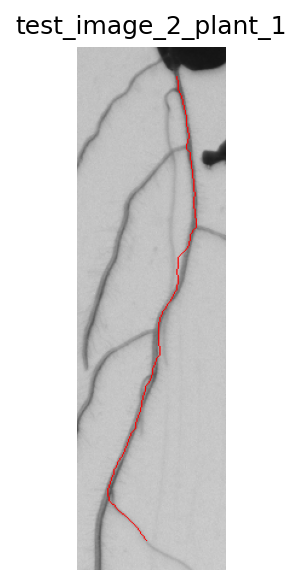

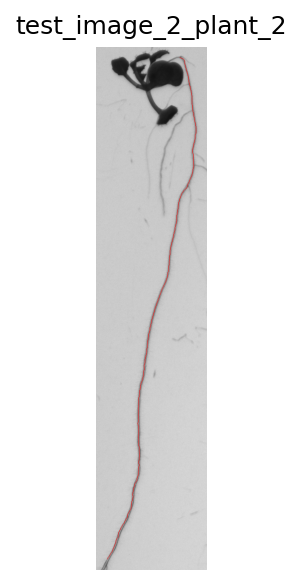

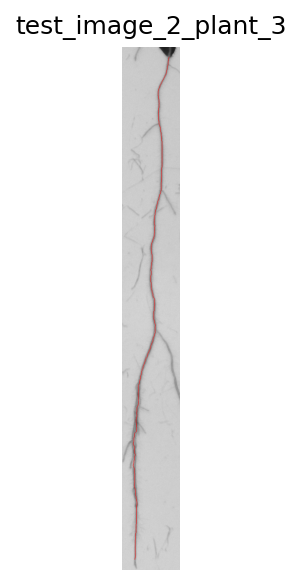

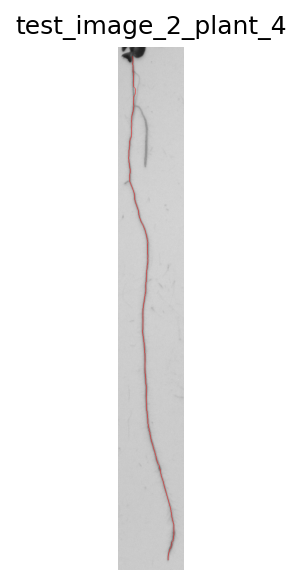

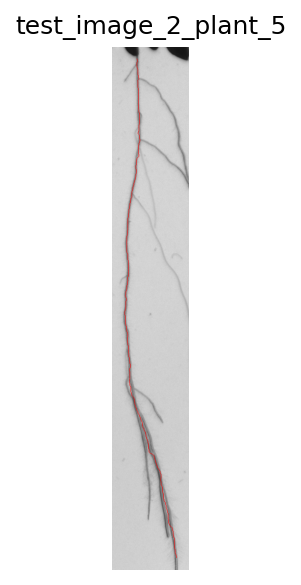

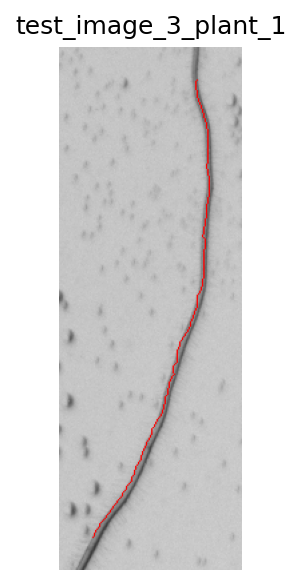

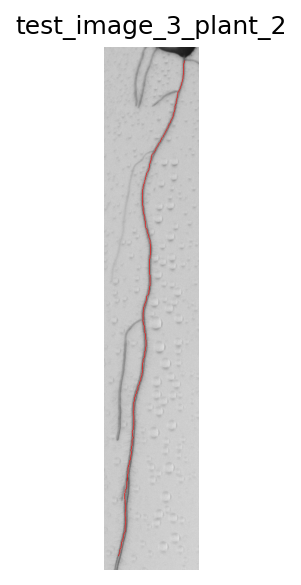

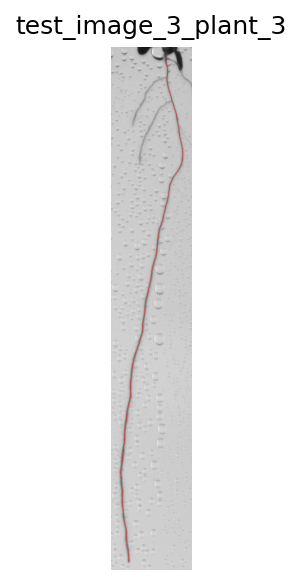

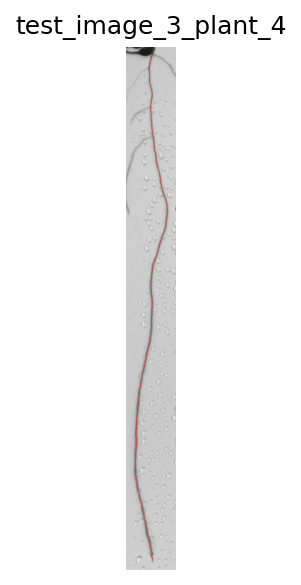

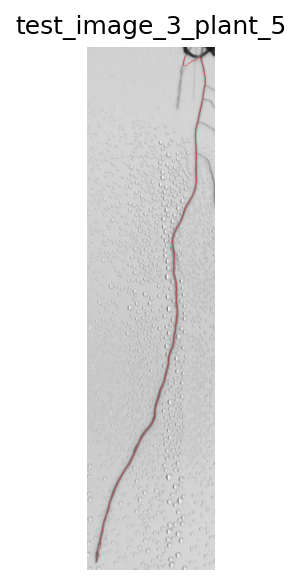

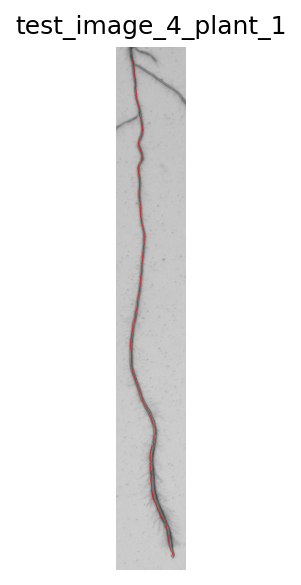

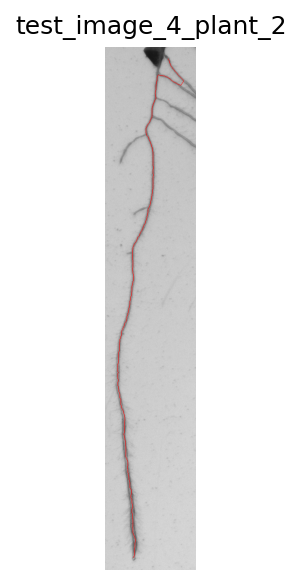

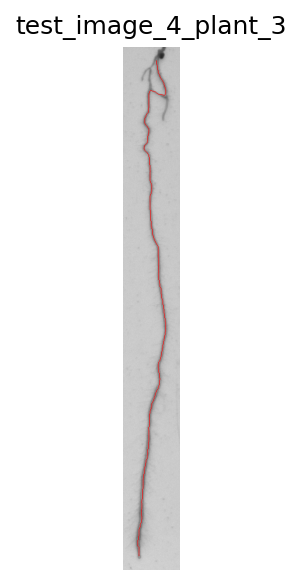

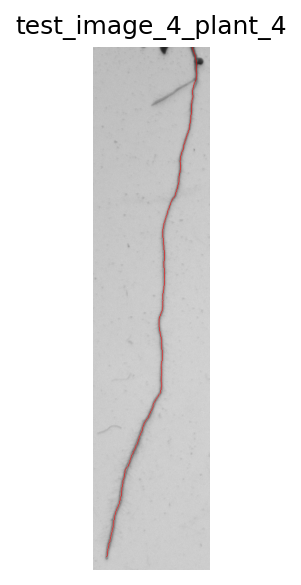

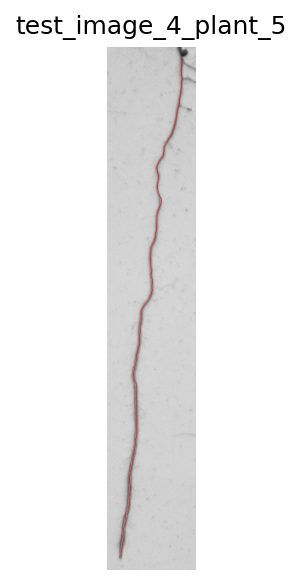

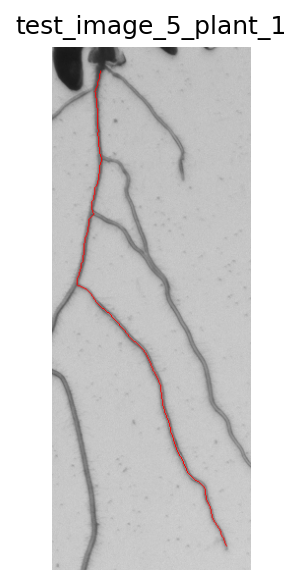

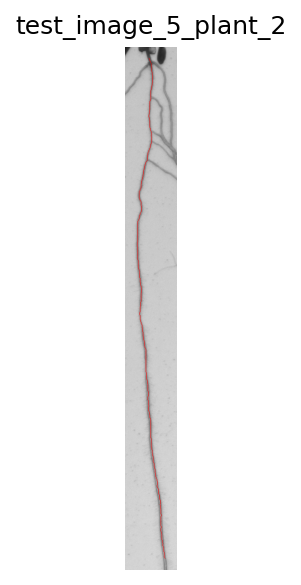

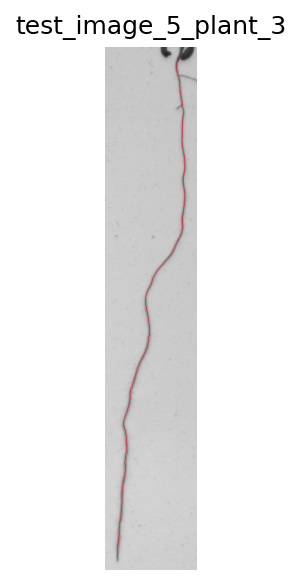

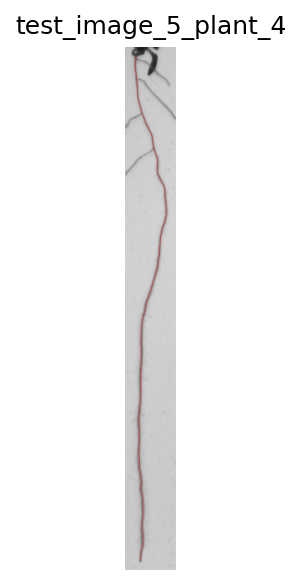

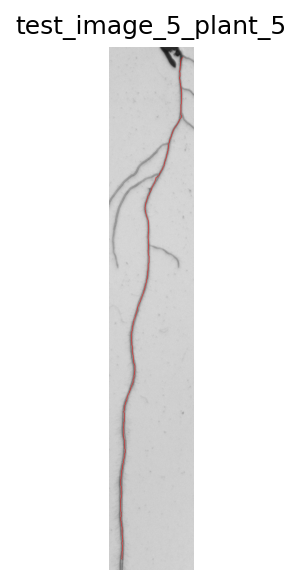

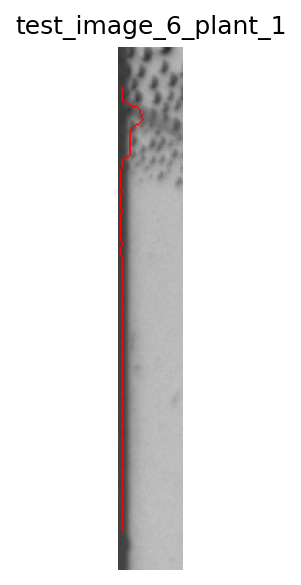

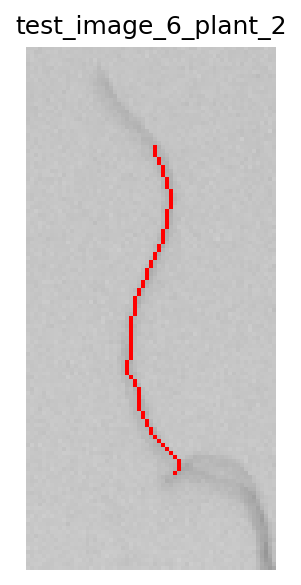

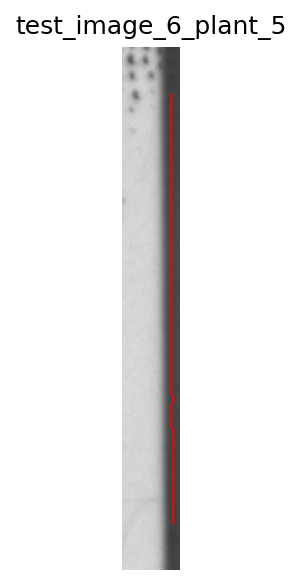

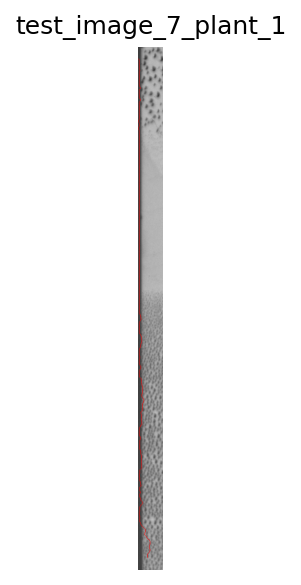

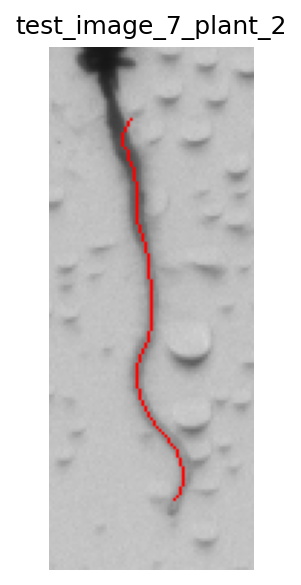

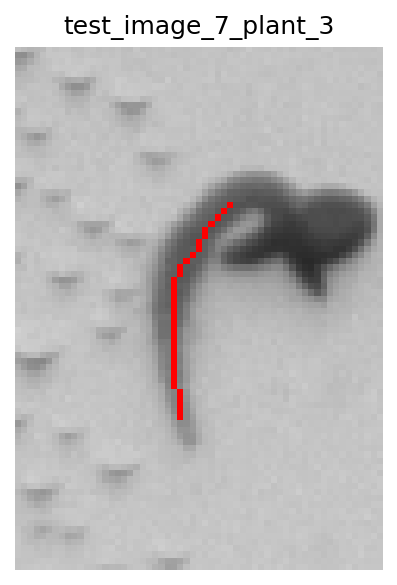

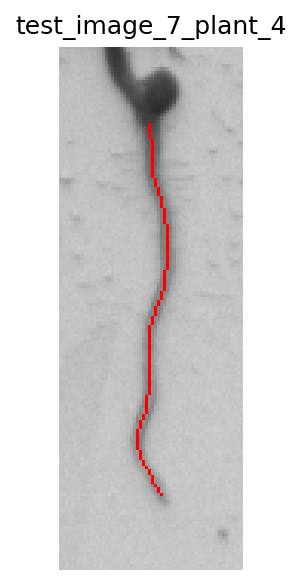

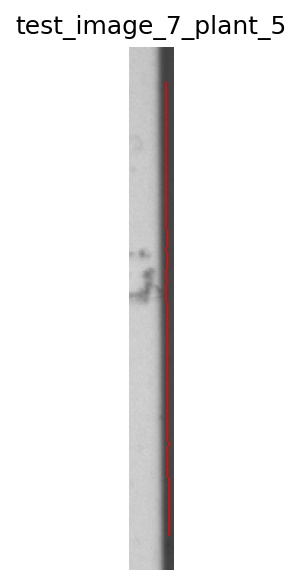

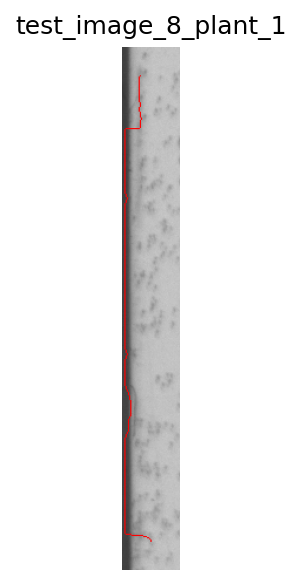

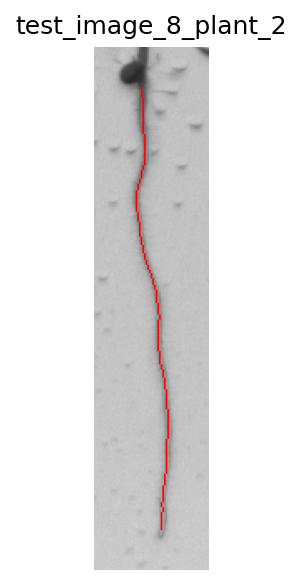

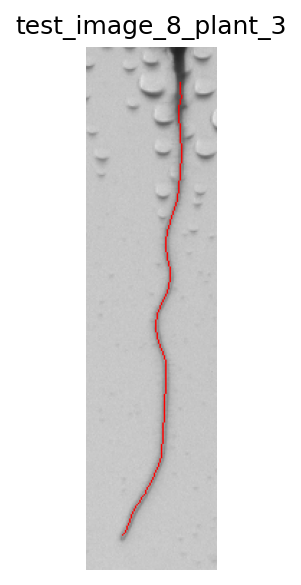

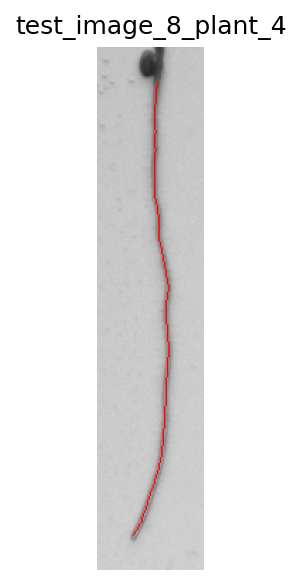

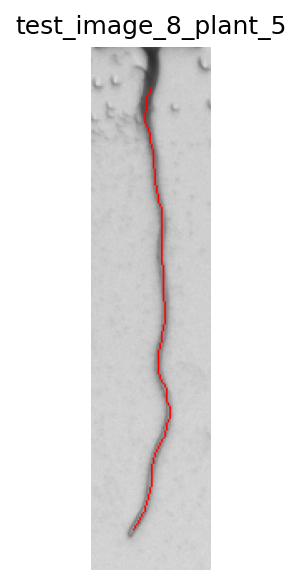

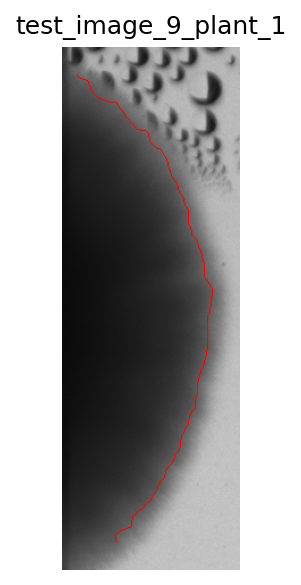

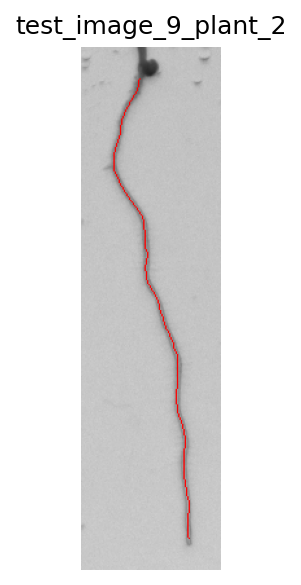

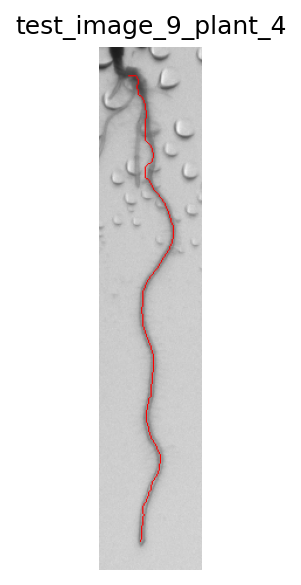

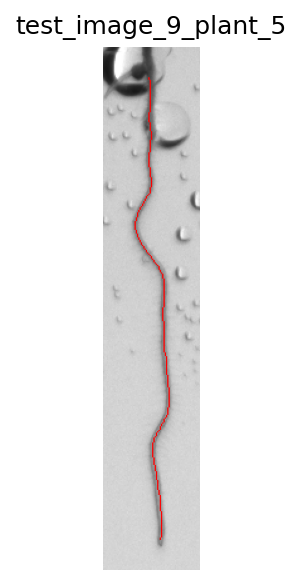

In [25]:
# Final overlays on original RGB images 
ORIGINAL_IMAGES_DIR = TEST_FOLDER
for key, m in final_root_masks.items():
    image_base = "_".join(key.split("_")[:-2]) + ".tif"
    img_path = os.path.join(ORIGINAL_IMAGES_DIR, image_base)
    rgb = cv2.imread(img_path)
    if rgb is None:
        continue
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)

    ci = raw_predictions[image_base]["crop_info"]
    xs, size = ci["x_start"], ci["crop_size"]
    xe = min(xs + size, rgb.shape[1])

    rgb_crop = rgb[:, xs:xe]
    tc = int(rgb_crop.shape[0] * TOP_CROP_RATIO)
    rgb_final = rgb_crop[tc:, :]

    gray = cv2.cvtColor(rgb_final, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    overlay = gray_rgb.copy()

    binary = (m > 0).astype(np.uint8)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    if num_labels <= 1:
        continue

    largest = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    comp = (labels == largest).astype(np.uint8)
    skel = skeletonize(comp)
    coords = np.argwhere(skel)
    coord_set = set(map(tuple, coords))

    G = nx.Graph()
    for y0, x0 in coords:
        for dy, dx in [(-1, 0), (1, 0), (0, -1), (0, 1),
                       (-1, -1), (-1, 1), (1, -1), (1, 1)]:
            nb = (y0 + dy, x0 + dx)
            if nb in coord_set:
                G.add_edge((y0, x0), nb, weight=np.hypot(dy, dx))

    if G.number_of_nodes() == 0:
        continue

    try:
        top_node = min(G.nodes, key=lambda n: n[0])
        bottom_node = max(G.nodes, key=lambda n: n[0])
        path = nx.dijkstra_path(G, source=top_node, target=bottom_node, weight='weight')
    except nx.NetworkXNoPath:
        continue

    pts = []
    for (yy, xx) in path:
        if 0 <= yy < overlay.shape[0] and 0 <= xx < overlay.shape[1]:
            overlay[yy, xx] = [255, 0, 0]
            pts.append((yy, xx))
    if not pts:
        continue

    pts = np.array(pts)
    y_min, x_min = pts.min(axis=0)
    y_max, x_max = pts.max(axis=0)
    margin = 25
    y_min = max(y_min - margin, 0); y_max = min(y_max + margin, overlay.shape[0])
    x_min = max(x_min - margin, 0); x_max = min(x_max + margin, overlay.shape[1])
    cropped_overlay = overlay[y_min:y_max, x_min:x_max]

    plt.figure(figsize=(4, 4), dpi=150)
    plt.imshow(cropped_overlay)
    plt.title(f"{key}"); plt.axis('off')
    plt.tight_layout(); plt.show()    

In [26]:
# Export CSV 
with open(CSV_OUT_PATH, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Plant ID", "Length (px)"])
    for plant_id, length in primary_root_lengths.items():
        writer.writerow([plant_id, length])

print(f"Saved primary root lengths to:\n{CSV_OUT_PATH}")

Saved primary root lengths to:
/Users/celinewu/Documents/GitHub/2024-25b-fai2-adsai-CelineWu231265/Retake/Submissions/sub3.csv
